#CSC3831 Final Assessment - Part 3: Deep Learning

##Load Dataset

In [27]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [28]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 training and test datasets
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


##1. Implement Early Stopping

###1.1 Define CNN model

In [29]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)

        # Define the fully connected layers
        self.fc1 = nn.Linear(4 * 4 * 64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        # Define the dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass through the convolutional layers with ReLU and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten the feature map
        x = x.view(-1, 4 * 4 * 64)

        # Forward pass through the fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

###1.2 Define Early Stopping

In [30]:
class EarlyStopping:
    # Intialise early stopping parameters
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf') # Initialise best loss
        self.counter = 0  # Intialise counter
        self.early_stop = False

    # Check if validation loss has improved
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss  # Update best loss
            self.counter = 0  # Reset counter
        else:
            self.counter += 1  # Increment counter

        # Stop training if the counter exceeds patience
        if self.counter >= self.patience:
            self.early_stop = True


###1.3 Define Training loop

In [31]:
# Train a model with early stopping and learning rate scheduling
def train_model(model, trainloader, testloader, optimiser, scheduler, criterion, epochs, patience, device, save_path='best_model.pth'):

    # Initialise variables to track loss and accuracy history
    running_loss_history = []
    running_corrects_history = []
    val_running_loss_history = []
    val_running_corrects_history = []

    # Initialise the early stopping object
    early_stopping = EarlyStopping(patience=patience)

    # Variables to track the best validation loss and model weights
    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in range(epochs):
        # Reset epoch metrics for training and validation
        running_loss = 0.0
        running_corrects = 0.0
        val_running_loss = 0.0
        val_running_corrects = 0.0

        # Training phase
        model.train()  # Set the model to training mode
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Set the parameters to zero
            optimiser.zero_grad()

            # Perform a forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Perform a backward pass and optimisation
            loss.backward()
            optimiser.step()

            # Calculate predictions and update metrics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

        # Calculate average training loss and accuracy for the epoch
        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_acc = running_corrects.float() / len(trainloader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc.cpu().numpy())

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for val_inputs, val_labels in testloader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                # Perform forward pass
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                # Calculate predictions and update metrics
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        # Calculate average validation loss and accuracy for the epoch
        val_epoch_loss = val_running_loss / len(testloader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(testloader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc.cpu().numpy())

        # Print metrics for the epoch
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}')

        # Save the best model based on validation loss
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, save_path)
            print(f"Best model updated and saved at epoch {epoch+1} with validation loss: {val_epoch_loss:.4f}")

        # Update early stopping
        early_stopping(val_epoch_loss)

        # Step the learning rate scheduler based on validation loss
        scheduler.step(val_epoch_loss)

        # Stop training if early stopping is triggered
        if early_stopping.early_stop:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

    # Load the best model weights before returning
    model.load_state_dict(best_model_wts)

    # Returns a dictionary containing the trained model and training/validation loss and accuracy histories
    return {
        "model": model,
        "running_loss_history": running_loss_history,
        "running_corrects_history": running_corrects_history,
        "val_running_loss_history": val_running_loss_history,
        "val_running_corrects_history": val_running_corrects_history,
    }

###1.4 Define Hyperparameters

In [32]:
learning_rate = 0.001
weight_decay = 1e-4
epochs = 50
patience = 10

###1.5 Intialise model, optimiser and scheduler

In [33]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialise the model and move it to the specified device
model_without_bn = CIFAR10CNN().to(device)

# Define the optimiser Adam with a learning rate
optimiser = optim.Adam(model_without_bn.parameters(), lr=learning_rate)

# Define a learning rate scheduler that reduces learning rate when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=5)

# Define the loss function
criterion = nn.CrossEntropyLoss()

###1.6 Train model

In [34]:
# Train the CIFAR10CNN model using early stopping
result_without_bn = train_model(
    model=model_without_bn,
    trainloader=trainloader,
    testloader=testloader,
    optimiser=optimiser,
    scheduler=scheduler,
    criterion=criterion,
    epochs=epochs,
    patience=patience,
    device=device,
    save_path='best_model_without_bn.pth'
)

Epoch 1/50, Train Loss: 0.0264, Accuracy: 0.3706
Validation Loss: 0.0221, Accuracy: 0.4810
Best model updated and saved at epoch 1 with validation loss: 0.0221
Epoch 2/50, Train Loss: 0.0210, Accuracy: 0.5114
Validation Loss: 0.0189, Accuracy: 0.5578
Best model updated and saved at epoch 2 with validation loss: 0.0189
Epoch 3/50, Train Loss: 0.0186, Accuracy: 0.5717
Validation Loss: 0.0170, Accuracy: 0.6177
Best model updated and saved at epoch 3 with validation loss: 0.0170
Epoch 4/50, Train Loss: 0.0171, Accuracy: 0.6128
Validation Loss: 0.0160, Accuracy: 0.6383
Best model updated and saved at epoch 4 with validation loss: 0.0160
Epoch 5/50, Train Loss: 0.0161, Accuracy: 0.6356
Validation Loss: 0.0155, Accuracy: 0.6420
Best model updated and saved at epoch 5 with validation loss: 0.0155
Epoch 6/50, Train Loss: 0.0153, Accuracy: 0.6556
Validation Loss: 0.0147, Accuracy: 0.6721
Best model updated and saved at epoch 6 with validation loss: 0.0147
Epoch 7/50, Train Loss: 0.0147, Accuracy

###1.7 Evaluate best model

In [35]:
# Initialise the model and load the best saved weights
model_with_bn = CIFAR10CNN().to(device)
model_with_bn.load_state_dict(torch.load('best_model_without_bn.pth', weights_only=True))

# Set the model to evaluation mode
model_with_bn.eval()

# Initialise variables to track test loss and accuracy
test_loss = 0.0
correct_preds = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in testloader:
        # Move inputs and labels to the specified device
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform forward pass
        outputs = model_with_bn(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get the predicted class labels and count correct predictions
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

# Calculate average test loss and accuracy
average_test_loss = test_loss / len(testloader.dataset)
test_accuracy = correct_preds.float() / total_samples

# Print the results
print(f"Test Loss: {average_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0111
Test Accuracy: 0.7499


###1.8 Implement graph function

In [36]:
# Plots the convergence graph for training and validation loss
def plot_convergence_graph(train_loss, val_loss, title="Convergence Graph"):

    # Set up the plot size
    plt.figure(figsize=(10, 6))

    # Plot training loss with a blue line
    plt.plot(train_loss, label="Training Loss", color='blue', linestyle='--')

    # Plot validation loss with an orange line
    plt.plot(val_loss, label="Validation Loss", color='orange', linestyle='-')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()

###1.9 Plot graph

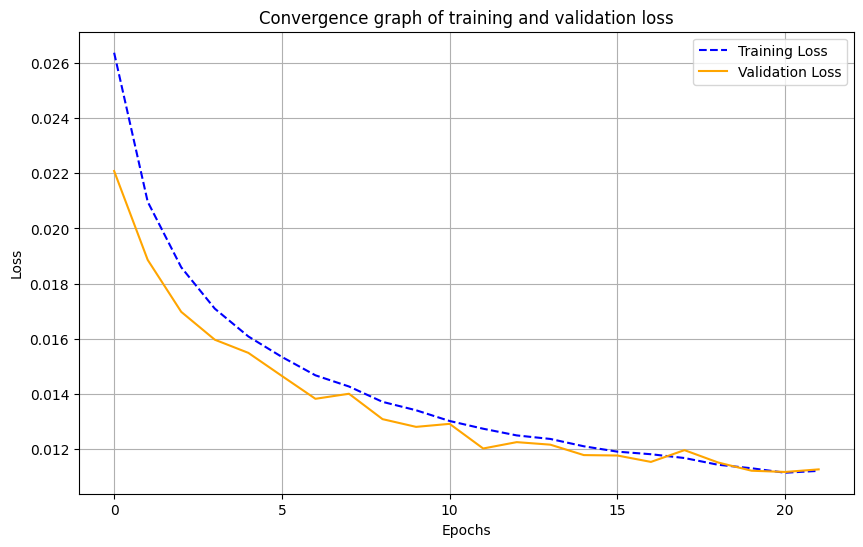

In [37]:
plot_convergence_graph(
    result_without_bn["running_loss_history"],
    result_without_bn["val_running_loss_history"],
    title="Convergence graph of training and validation loss"
)

##2. CNN with and without batch normalisation

###2.1 Define CNN with batch normalisation

In [38]:
class CIFAR10CNNBN(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the convolutional layers with batch normalisation
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Define the fully connected layers
        self.fc1 = nn.Linear(4 * 4 * 64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        # Define the dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass through the convolutional layers with ReLU and max pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)

        # Flatten the feature map
        x = x.view(-1, 4 * 4 * 64)

        # Forward pass through the fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

###2.2 Intialise model, optimiser and scheduler

In [39]:
model_with_bn = CIFAR10CNNBN().to(device)
optimiser = optim.Adam(model_with_bn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=5)
criterion = nn.CrossEntropyLoss()

###2.3 Train model

In [40]:
# Train the CIFAR10CNNBN model with using early stopping
result_with_bn = train_model(
    model=model_with_bn,
    trainloader=trainloader,
    testloader=testloader,
    optimiser=optimiser,
    scheduler=scheduler,
    criterion=criterion,
    epochs=epochs,
    patience=patience,
    device=device,
    save_path='best_model_with_bn.pth'
)

Epoch 1/50, Train Loss: 0.0246, Accuracy: 0.4106
Validation Loss: 0.0208, Accuracy: 0.5118
Best model updated and saved at epoch 1 with validation loss: 0.0208
Epoch 2/50, Train Loss: 0.0199, Accuracy: 0.5391
Validation Loss: 0.0174, Accuracy: 0.6044
Best model updated and saved at epoch 2 with validation loss: 0.0174
Epoch 3/50, Train Loss: 0.0179, Accuracy: 0.5899
Validation Loss: 0.0162, Accuracy: 0.6323
Best model updated and saved at epoch 3 with validation loss: 0.0162
Epoch 4/50, Train Loss: 0.0165, Accuracy: 0.6233
Validation Loss: 0.0149, Accuracy: 0.6718
Best model updated and saved at epoch 4 with validation loss: 0.0149
Epoch 5/50, Train Loss: 0.0156, Accuracy: 0.6452
Validation Loss: 0.0153, Accuracy: 0.6600
Epoch 6/50, Train Loss: 0.0149, Accuracy: 0.6640
Validation Loss: 0.0139, Accuracy: 0.6909
Best model updated and saved at epoch 6 with validation loss: 0.0139
Epoch 7/50, Train Loss: 0.0145, Accuracy: 0.6743
Validation Loss: 0.0141, Accuracy: 0.6736
Epoch 8/50, Train 

###2.4 Evaluate best model

In [41]:
# Initialise the model and load the best saved weights
model_with_bn = CIFAR10CNNBN().to(device)
model_with_bn.load_state_dict(torch.load('best_model_with_bn.pth', weights_only=True))

# Set the model to evaluation mode
model_with_bn.eval()

# Initialise variables to track test loss and accuracy
test_loss = 0.0
correct_preds = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in testloader:
        # Move inputs and labels to the specified device
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform forward pass
        outputs = model_with_bn(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get the predicted class labels and count correct predictions
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

# Calculate average test loss and accuracy
average_test_loss = test_loss / len(testloader.dataset)
test_accuracy = correct_preds.float() / total_samples

# Print the results
print(f"Test Loss: {average_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0106
Test Accuracy: 0.7686


###2.5 Plot graph

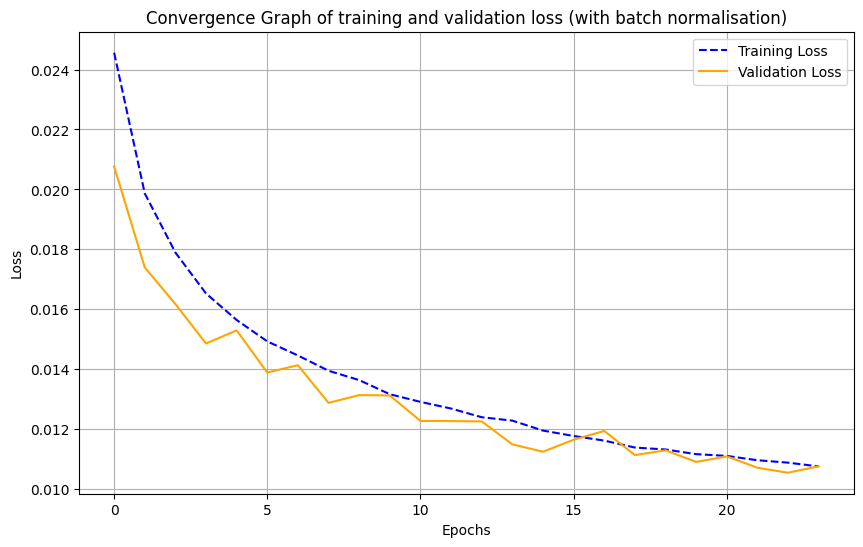

In [42]:
plot_convergence_graph(
    result_with_bn["running_loss_history"],
    result_with_bn["val_running_loss_history"],
    title="Convergence Graph of training and validation loss (with batch normalisation)"
)

###2.6 Comparison graph function

In [43]:
# Plots a comparison graph showing training and validation loss for models with and without batch normalisation
def plot_comparison_graph(train_loss_bn, val_loss_bn, train_loss_no_bn, val_loss_no_bn):

    plt.figure(figsize=(12, 8))

    # Plot training and validation loss for the model with Batch Normalisation
    plt.plot(train_loss_bn, label="Train Loss (With Batch Norm)", color='blue', linestyle='--')
    plt.plot(val_loss_bn, label="Validation Loss (With Batch Norm)", color='orange', linestyle='-')

    # Plot training and validation loss for the model without Batch Normalisation
    plt.plot(train_loss_no_bn, label="Train Loss (Without Batch Norm)", color='green', linestyle='--')
    plt.plot(val_loss_no_bn, label="Validation Loss (Without Batch Norm)", color='red', linestyle='-')

    # Add labels and title
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Comparison of models with and without Batch Normalisation")

    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()

###2.7 Plot comparison graph

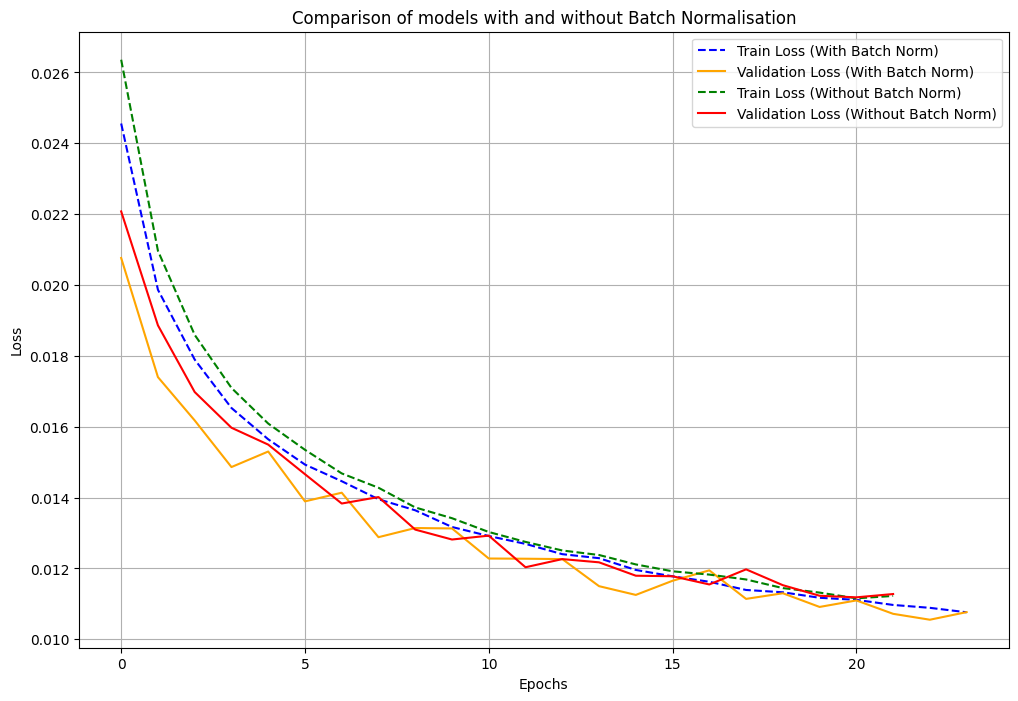

In [44]:
plot_comparison_graph(
    train_loss_bn=result_with_bn["running_loss_history"],
    val_loss_bn=result_with_bn["val_running_loss_history"],
    train_loss_no_bn=result_without_bn["running_loss_history"],
    val_loss_no_bn=result_without_bn["val_running_loss_history"]
)

###Analysis

##3. Visualise the Convolutional Features / Filters

###3.1 Load best model

In [45]:
model_with_bn = CIFAR10CNNBN().to(device)

# Load the pre-trained weights of the best model with Batch normalisation
model_with_bn.load_state_dict(torch.load('best_model_with_bn.pth', weights_only=True))

# Set the model to evaluation mode
model_with_bn.eval()

CIFAR10CNNBN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

###3.1 Visualise filters

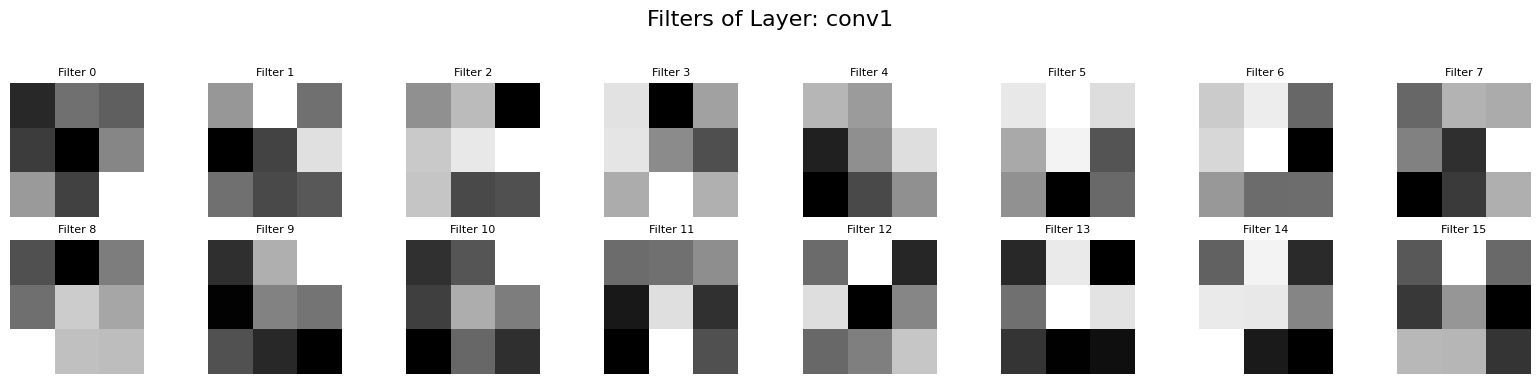

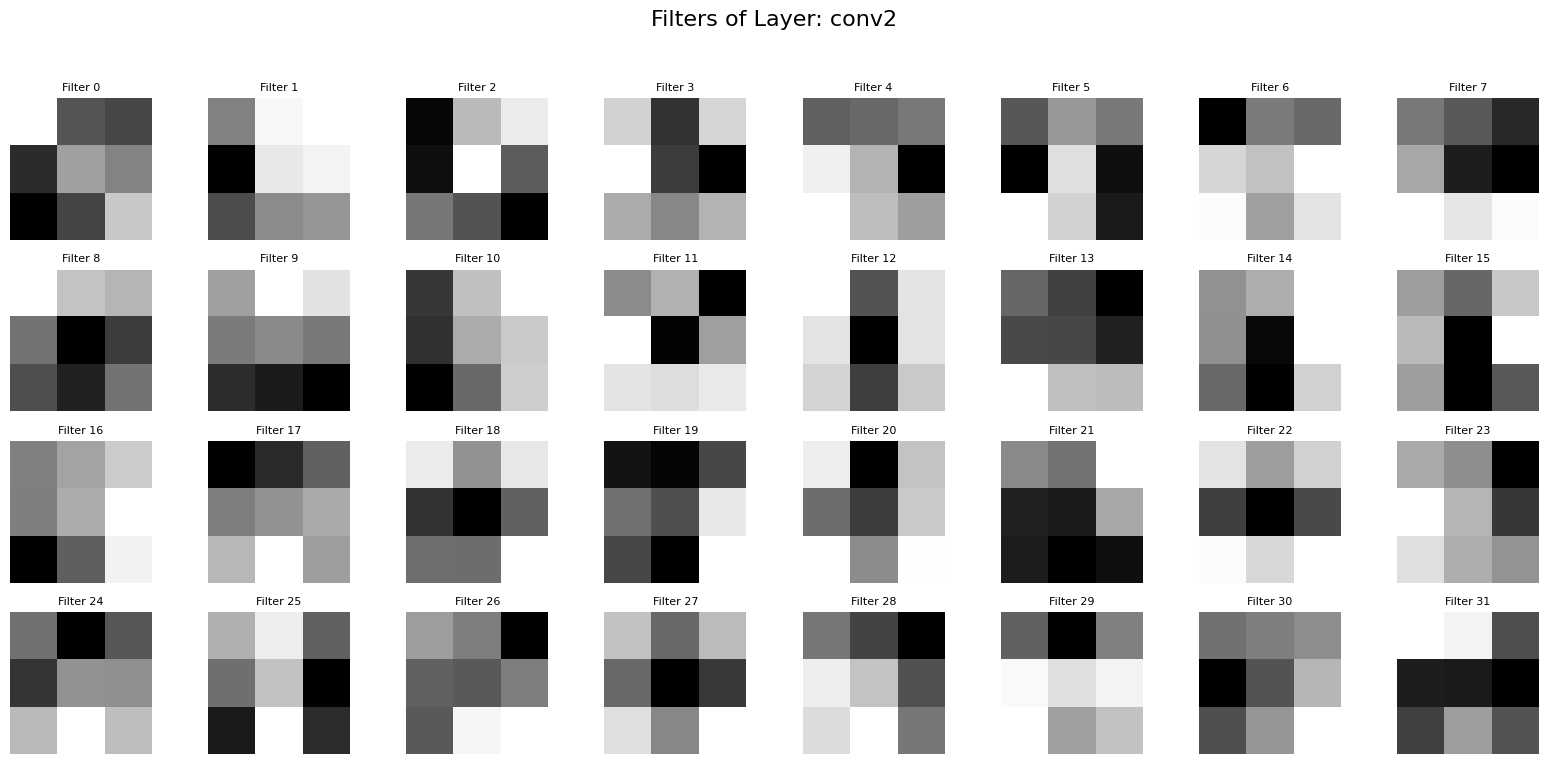

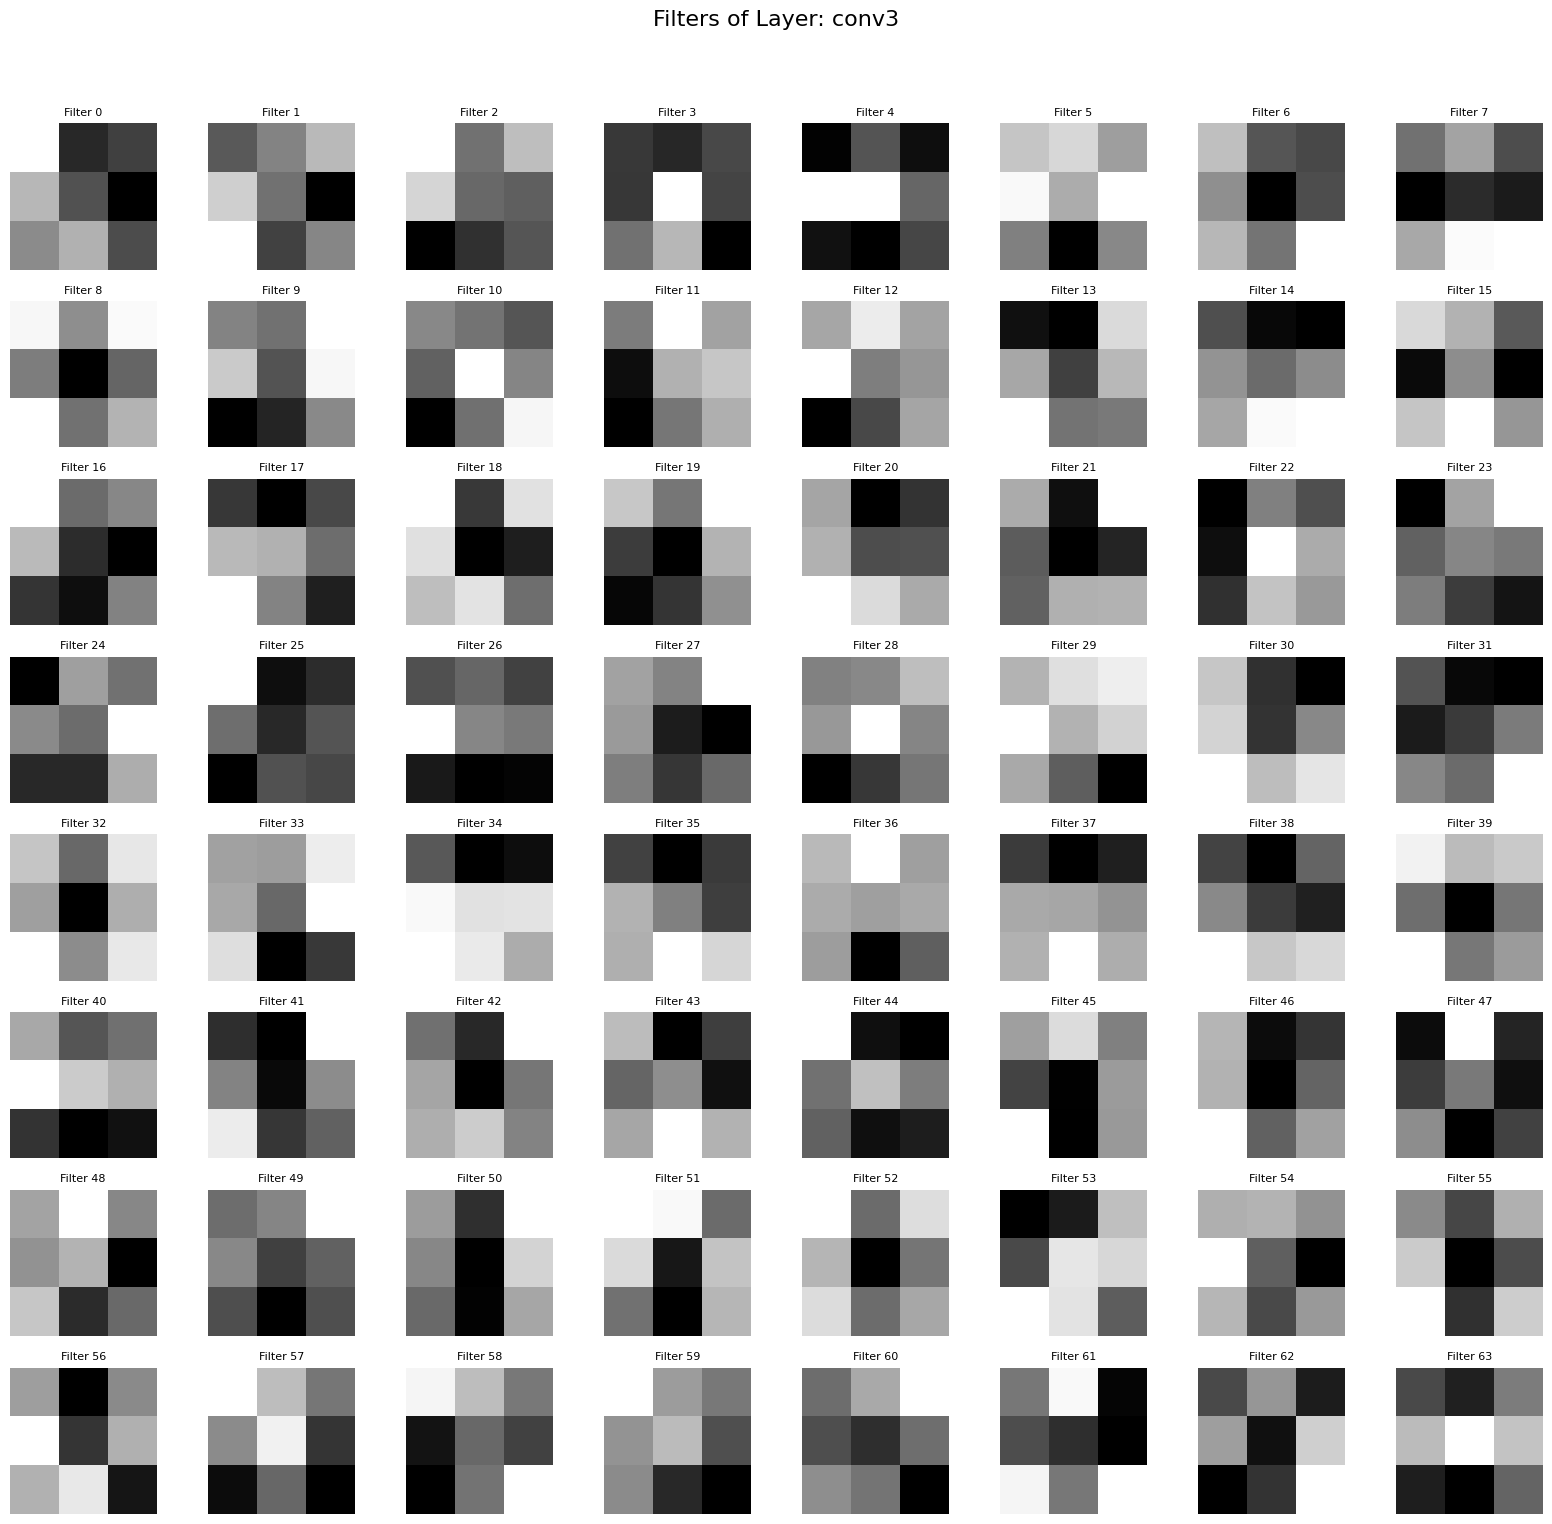

In [46]:
def visualise_filters(model, layer_name):
    import matplotlib.pyplot as plt
    import numpy as np

    # Retrieve the specified layer from the model
    layer = dict(model.named_modules())[layer_name]

    # Extract the filter weights
    filters = layer.weight.data.cpu().numpy()

    # Determine the number of filters
    num_filters = filters.shape[0]

    # Define a rectangular grid: more columns than rows
    num_columns = 8  # You can adjust this number to make it more "lengthwise"
    num_rows = int(np.ceil(num_filters / num_columns))

    # Create subplots to display the filters
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))
    fig.suptitle(f'Filters of Layer: {layer_name}', fontsize=16)

    # Loop through the grid and plot each filter
    axes = axes.ravel()  # Flatten the grid to make it easier to loop through
    for idx, ax in enumerate(axes):
        if idx < num_filters:
            ax.imshow(filters[idx][0], cmap='gray')  # Visualize the first channel of each filter
            ax.set_title(f'Filter {idx}', fontsize=8)
        else:
            ax.axis('off')  # Turn off empty subplots

        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Display the filters grid
    plt.show()

# Visualise filters from different convolutional layers in the model with batch Normalisation
visualise_filters(model_with_bn, 'conv1')
visualise_filters(model_with_bn, 'conv2')
visualise_filters(model_with_bn, 'conv3')

###3.3 Visualise Convolutional Features

In [47]:
# A hook function that captures the output of a specific layer
def get_activation(name):

    def hook(model, input, output):
        # Store the activations of the layer in the global 'activations' dictionary.
        activations[name] = output.detach()
    return hook

# Dictionary to store the activations of the layers.
activations = {}

# List of layer names to register hooks on.
layer_names = ['conv1', 'conv2', 'conv3']

# Loop through the specified layer names.
for name in layer_names:
    # Retrieve the layer from the model using its name.
    layer = dict(model_with_bn.named_modules())[name]

    # Register a forward hook on the layer to capture its output during inference.
    layer.register_forward_hook(get_activation(name))

###3.3.1 Load target image

In [48]:
# Retrieve a single batch of test images from the testloader
test_image, _ = next(iter(testloader))

# Move the test images to the same device as the model
test_image = test_image.to(device)

# Perform a forward pass through the model with batch normalisation
with torch.no_grad():
    model_with_bn(test_image)

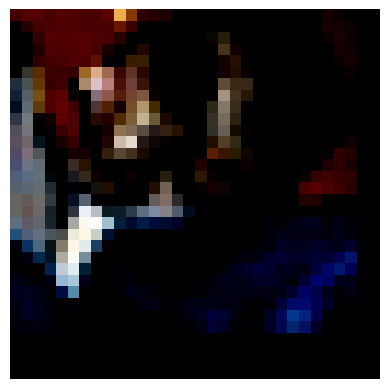

In [49]:
def visualise_image(image_tensor):
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))

    # Display the image using matplotlib.
    plt.imshow(image)
    plt.axis('off')  # Remove axes for a cleaner display.
    plt.show()

# Visualize the first image from the test batch.
visualise_image(test_image[0])

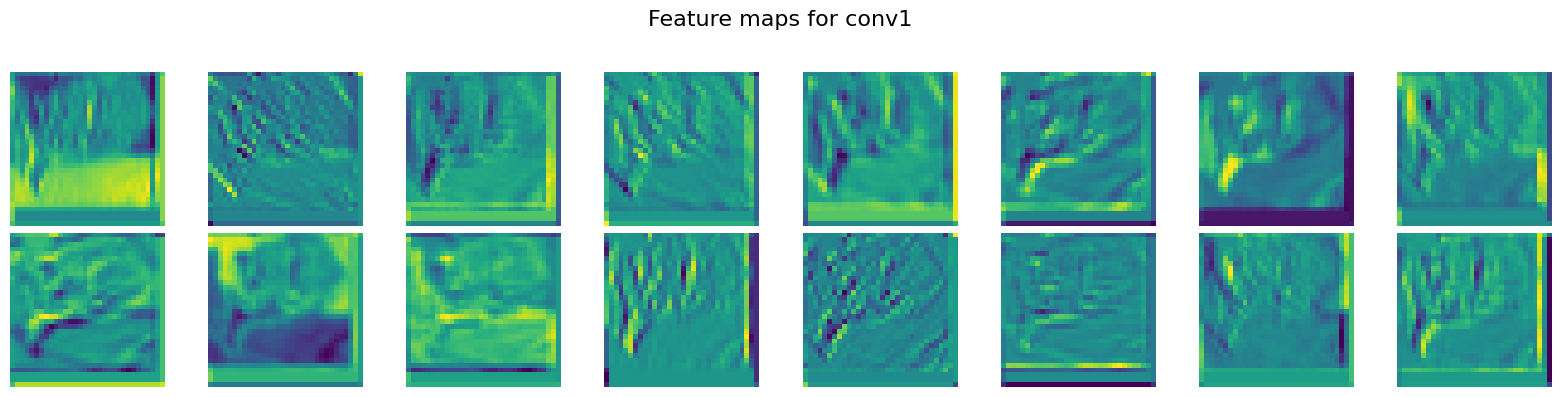

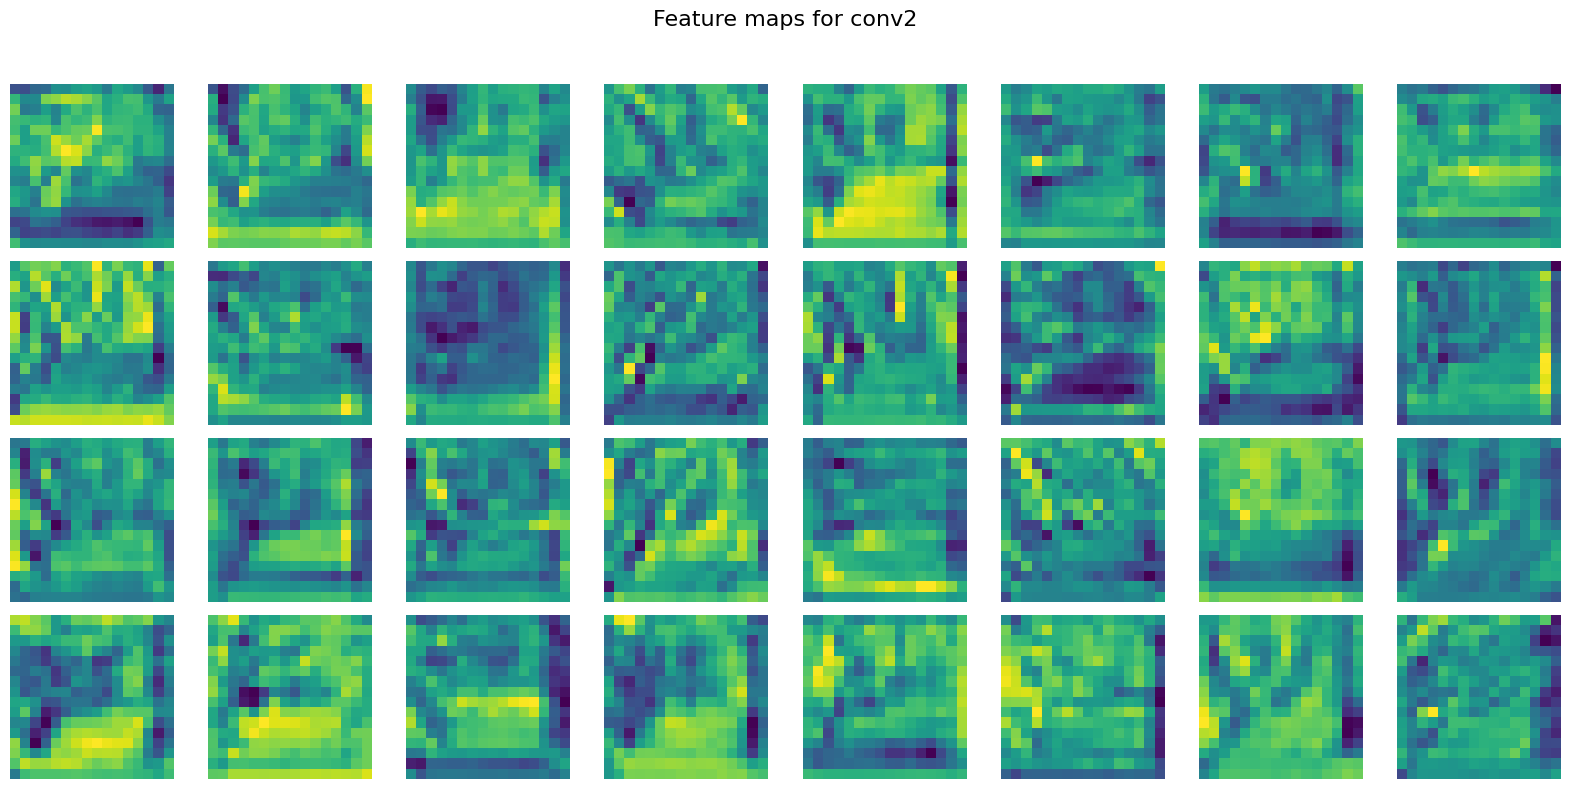

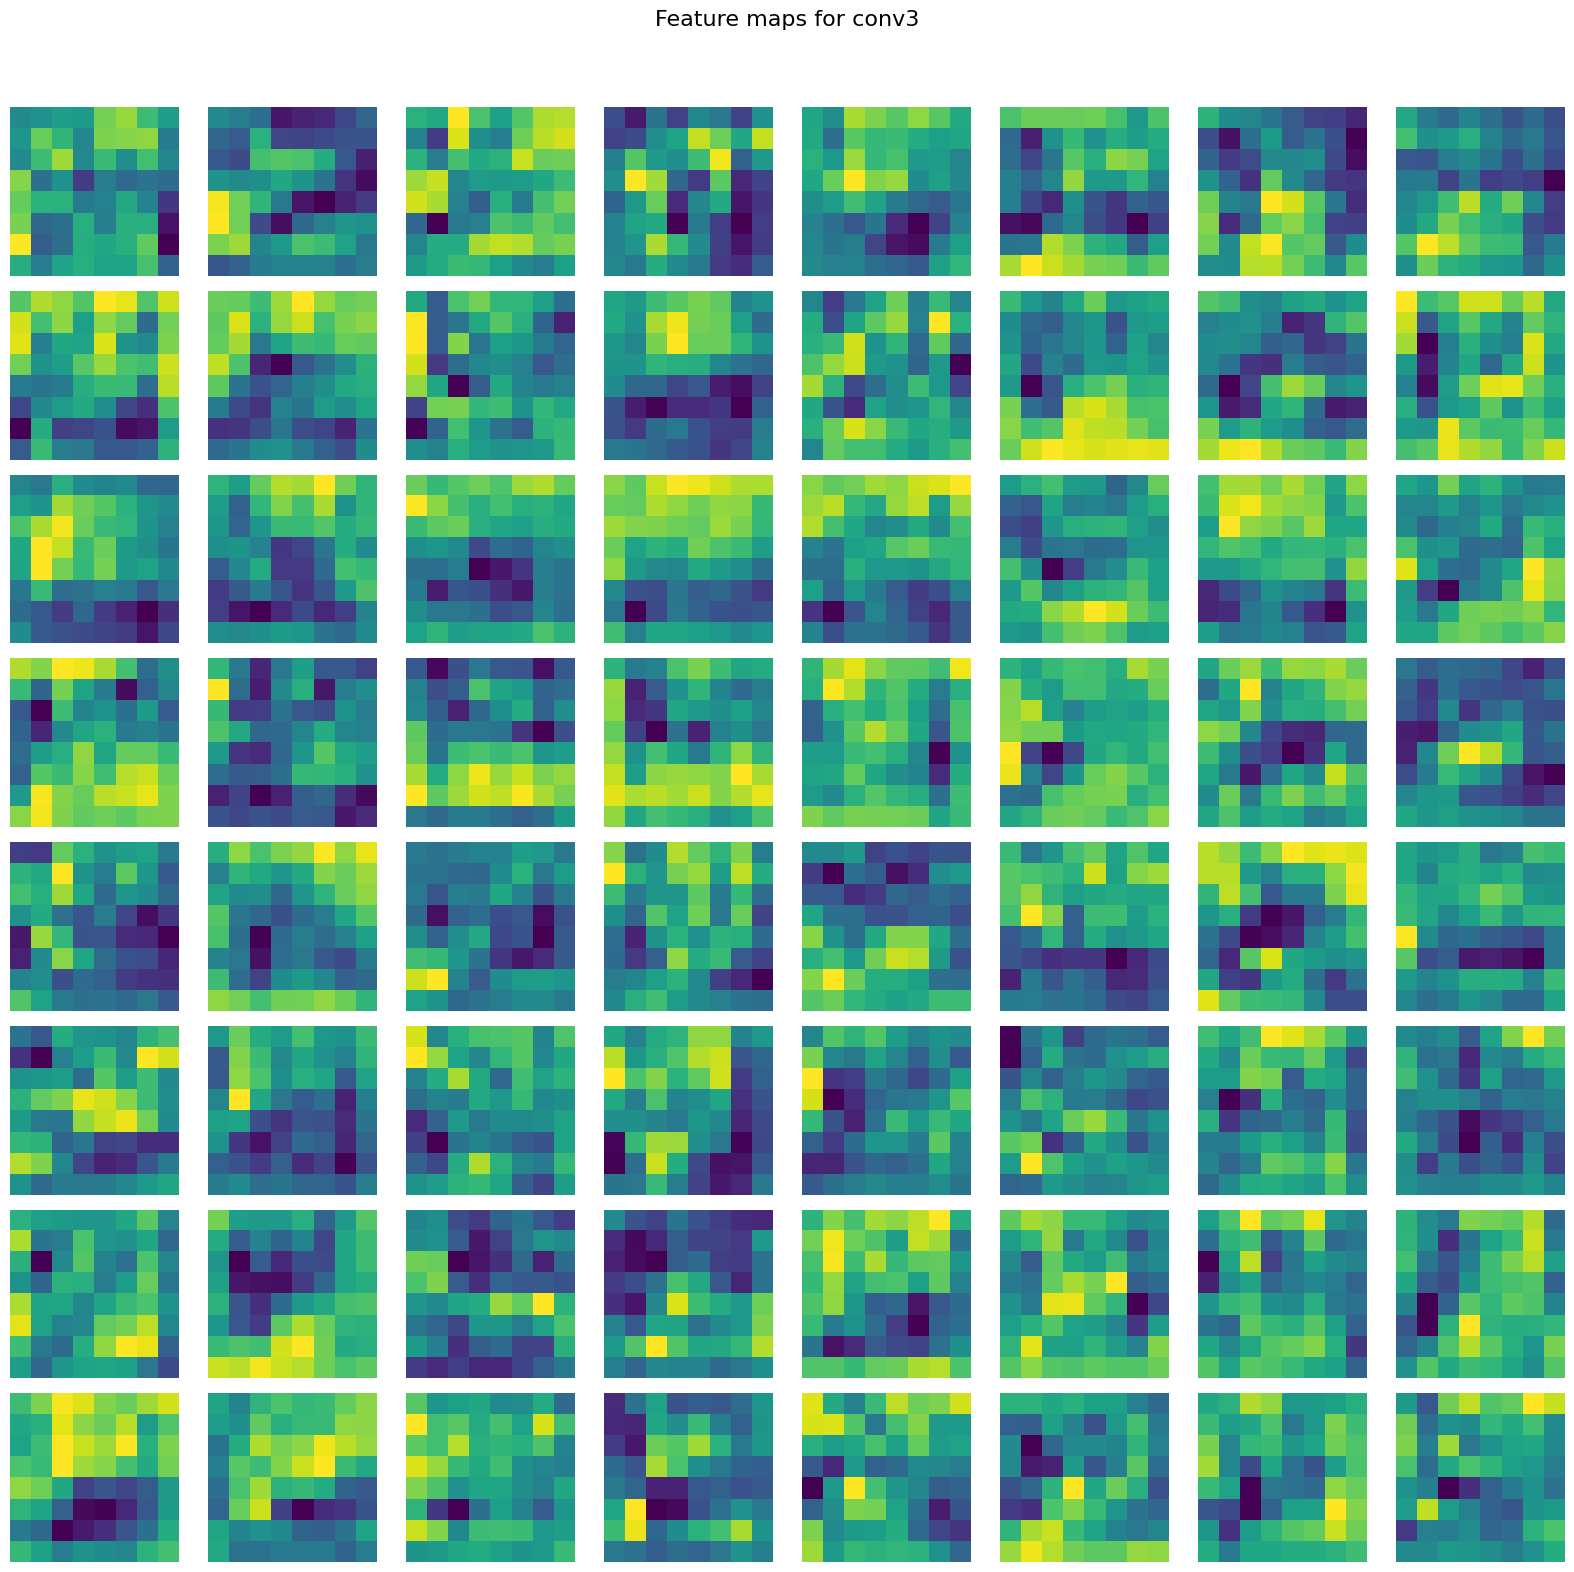

In [50]:
import math
import numpy as np
import matplotlib.pyplot as plt

def visualise_feature_maps(activation, layer_name):
    act = activation[0].cpu().numpy()
    num_features = act.shape[0]

    # Define the grid shape for a more rectangular display
    n_cols = 8  # Set number of columns for a rectangular layout
    n_rows = math.ceil(num_features / n_cols)

    # Create a grid of subplots for visualising the feature maps
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 2))  # Adjust size for readability

    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j] if n_rows > 1 else axes[j]
            idx = i * n_cols + j
            if idx < num_features:
                ax.imshow(act[idx], cmap='viridis')
            ax.axis('off')  # Turn off axis for better visualisation

    # Remove any unused subplots
    for idx in range(num_features, n_rows * n_cols):
        if n_rows > 1:
            axes[idx // n_cols, idx % n_cols].axis('off')
        else:
            axes[idx % n_cols].axis('off')

    plt.suptitle(f'Feature maps for {layer_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()

# Visualise activations for all layers
for layer_name in layer_names:
    visualise_feature_maps(activations[layer_name], layer_name)